# From the address to the 3D

In [74]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns

import geopy as gp
import folium

from shapely.geometry import Point

import rasterio as rio
from rasterio.plot import show
from rasterio.windows import Window

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from pylidar import lidarprocessor
from pylidar.toolbox import interpolation
from pylidar.toolbox import spatial
from functools import partial
import pyproj
import ipyvolume.pylab as p3
from tqdm import tqdm

In [24]:
from functions import *

## Enter an address, get a location

In [5]:
# Google API (quand compte ok)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.geocoders.GoogleV3(api_key='')
    location = locator.geocode(address, timeout=10)
    print(location.raw)
    print(location.address)
    postcode = location.address['postcode']
    country_code = location.address['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[1], coord[0], postcode))

Please, enter an address in Begium:
Gare de Namur


<ipython-input-5-f8019876c1a0>:8: UserWarning: Since July 2018 Google requires each request to have an API key. Pass a valid `api_key` to GoogleV3 geocoder to hide this warning. See https://developers.google.com/maps/documentation/geocoding/usage-and-billing
  locator = gp.geocoders.GoogleV3(api_key='')


GeocoderUnavailable: HTTPSConnectionPool(host='maps.googleapis.com', port=443): Max retries exceeded with url: /maps/api/geocode/json?sensor=false&address=Gare+de+Namur (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020A5EBF2430>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [26]:
# OpenStreet Map (gratuit, moins efficace)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.Nominatim(user_agent="myGeocoder")
    location = locator.geocode(address, addressdetails=True)
    
    postcode = int(location.raw['address']['postcode'])
    country_code = location.raw['address']['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[0], coord[1], postcode))

Please, enter an address in Begium:
Gare de Namur
Latitude = 50.469100100000006, Longitude = 4.862421313946799, Postcode = 5000


In [27]:
mappy = folium.Map(
    location=[coord[0],coord[1]],
    zoom_start=17
)

folium.CircleMarker(
    location=[coord[0],coord[1]],
    radius=30,
    popup='Your address',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(mappy)

mappy

## Get the corrects LiDAR files' path

In [28]:
path_dsm = ""
path_dtm = ""
flanders = False

if postcode >= 1300 and postcode < 1500:
    path_dsm = set_path_dsm('BRABANT_WALLON')
    path_dtm = set_path_dtm('BRABANT_WALLON')
    print('Walloon Brabant')
    
elif postcode >= 4000 and postcode < 5000:
    path_dsm = set_path_dsm('LIEGE')
    path_dtm = set_path_dtm('LIEGE')
    print('Liège')
    
elif postcode >= 5000 and postcode < 6000:
    path_dsm = set_path_dsm('NAMUR')
    path_dtm = set_path_dtm('NAMUR')
    print('Namur')
    
elif (postcode >= 6000 and postcode < 6600) or (postcode >= 7000 and postcode < 8000):
    path_dsm = set_path_dsm('HAINAUT')
    path_dtm = set_path_dtm('HAINAUT')
    print('Hainaut')
    
elif postcode >= 6600 and postcode < 7000:
    path_dsm = set_path_dsm('LUXEMBOURG')
    path_dtm = set_path_dtm('LUXEMBOURG')
    print('Luxembourg')
    
else:
    number = [x for x in range(1, 44)]
    for i in number :
        pass
    flanders = True
    print('Brussels or Flanders region')

Namur


## From coordinates to correct crs

In [29]:
# Walloon region uses EPSG:31370
# Flanders region uses EPSG:?

if flanders == False:
    p = gpd.GeoSeries([Point(coord[1], coord[0])])
    p.crs = 'epsg:4326'
    p = p.to_crs(epsg=31370)
    print(p[0])
else:
    pass



POINT (185046.4410823517 128813.7578461301)


C:\Users\morga\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Get a sample of the LiDARs, center on the coordinates

##### DSM

D:/Resources/Wallonia/DSM 2013-2014/RELIEF_WALLONIE_MNS_2013_2014_GEOTIFF_31370_PROV_NAMUR/RELIEF_WALLONIE_MNS_2013_2014.tif
Pixel Y, X coords: 21186, 41046
(98000, 80000)


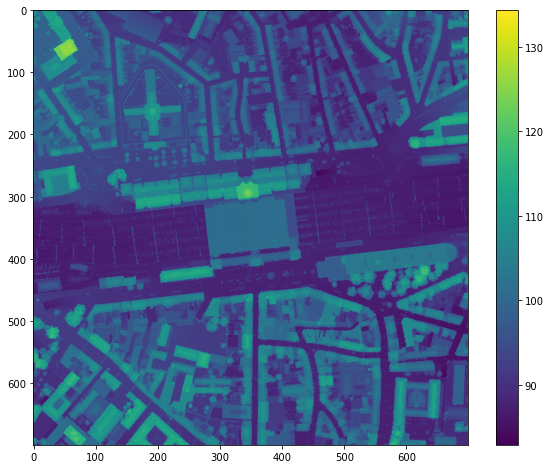

In [82]:
coordinates = (
    (p[0].x, p[0].y),
)

# Window's size
N = 700

print(path_dsm)

with rio.open(path_dsm) as dsm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dsm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dsm = dsm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dsm_meta = dsm.profile

plt.figure(figsize=(10, 8))
plt.imshow(small_dsm)
plt.colorbar()
plt.show()

##### DTM

Pixel Y, X coords: 21186, 41046


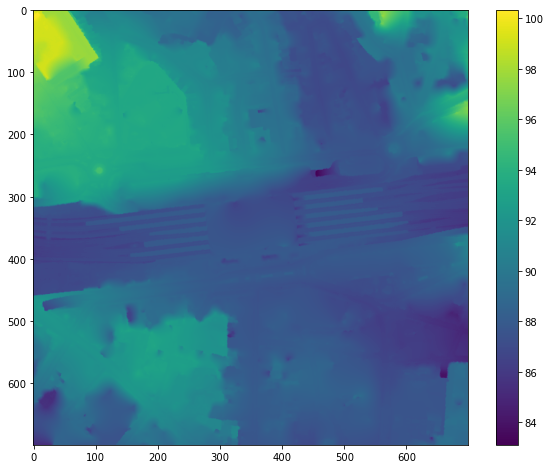

In [31]:
with rio.open(path_dtm) as dtm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dtm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dtm = dtm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dtm_meta = dtm.profile

plt.figure(figsize=(10, 8))
plt.imshow(small_dtm)
plt.colorbar()
plt.show()

## Canopy Height Model and Hillshade

DSM - DTM = CHM

In [44]:
lidar_chm = small_dsm - small_dtm

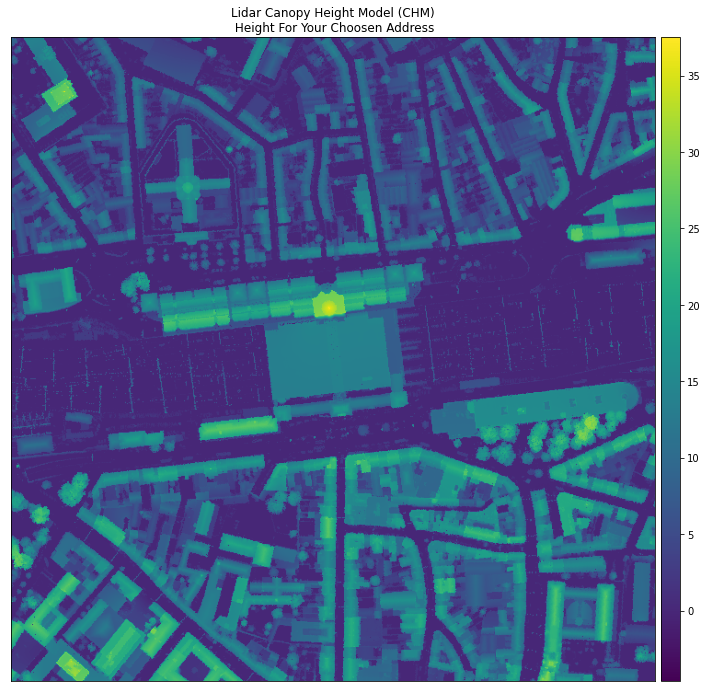

In [45]:
ep.plot_bands(lidar_chm,
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)\n Height For Your Choosen Address")
plt.show()

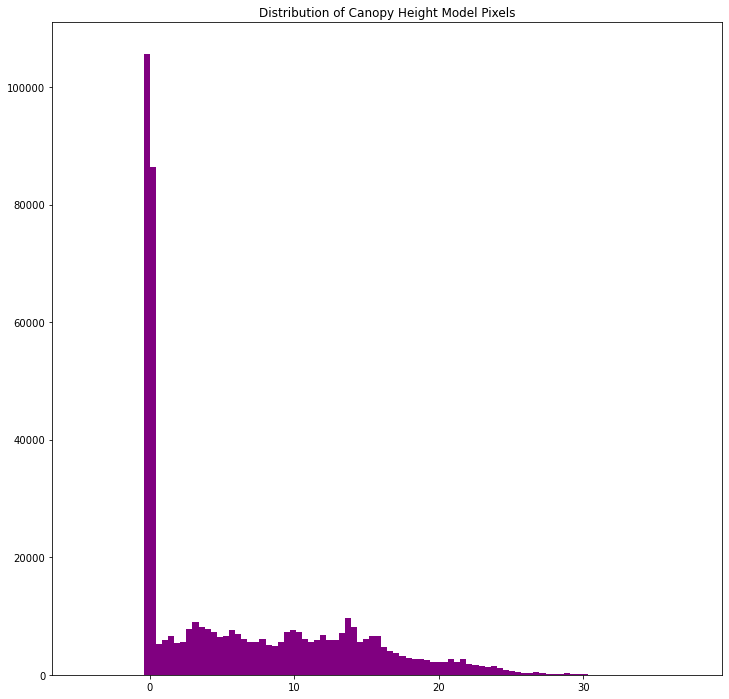

In [41]:
# view histogram of the data
ep.hist(lidar_chm,
        bins=100,
        title="Distribution of Canopy Height Model Pixels")
plt.show()


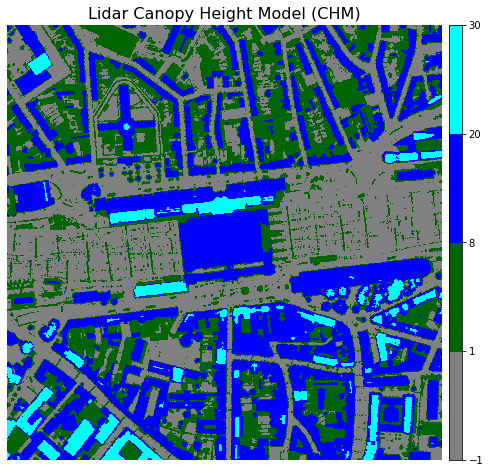

In [35]:
# Show the CHM with others colors

# Define the colors
cmap = ListedColormap(["grey", "darkgreen", "blue", "cyan"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([-1, 1, 8, 20, 30], 5)

fig, ax = plt.subplots(figsize=(12, 8))
chm_plot = ax.imshow(lidar_chm, 
                     cmap=cmap, 
                     norm=norm)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16)
ep.colorbar(chm_plot)
ax.set_axis_off()
plt.show()


## Cleaning

In [46]:
# CLEANUP: Set CHM values of 1 or less to NAN
clean_lidar_chm = small_dsm - small_dtm
clean_lidar_chm[clean_lidar_chm <= 1] = np.nan

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(lidar_chm))
print('Max:', np.nanmax(lidar_chm))
print('Min:', np.nanmin(lidar_chm))

Mean: 6.3350453
Max: 37.489265
Min: -4.6289215


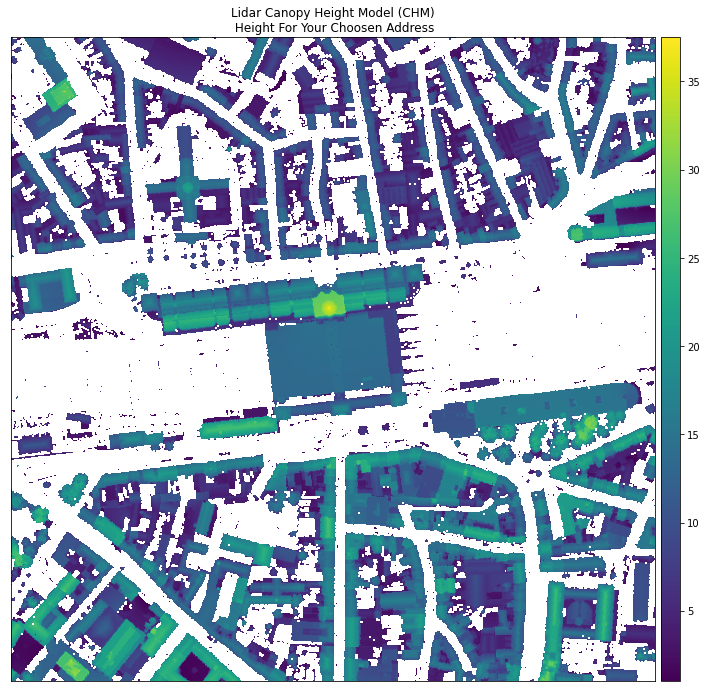

In [47]:
ep.plot_bands(clean_lidar_chm,
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)\n Height For Your Choosen Address")
plt.show()

## Getting a Hillshade

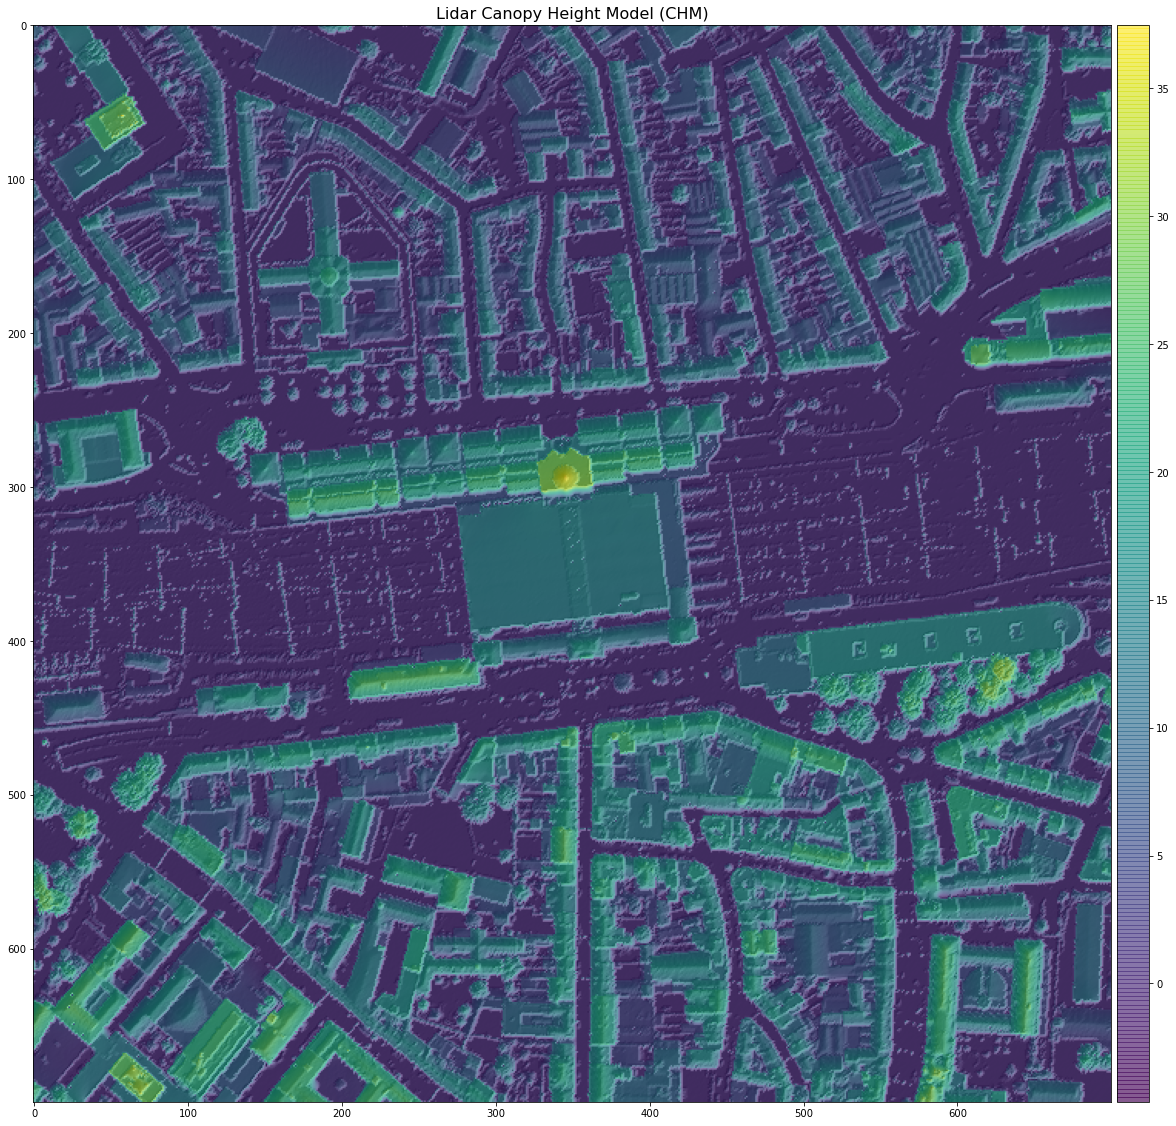

In [48]:
# create hillshade using hillshade function in earthpy
chm_hill = es.hillshade(lidar_chm, 315, 45)

# plot the data
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(chm_hill, cmap='Greys')
chm_plot = ax.imshow(lidar_chm, 
                     cmap='viridis', 
                     alpha = .65)

ep.colorbar(chm_plot)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16)



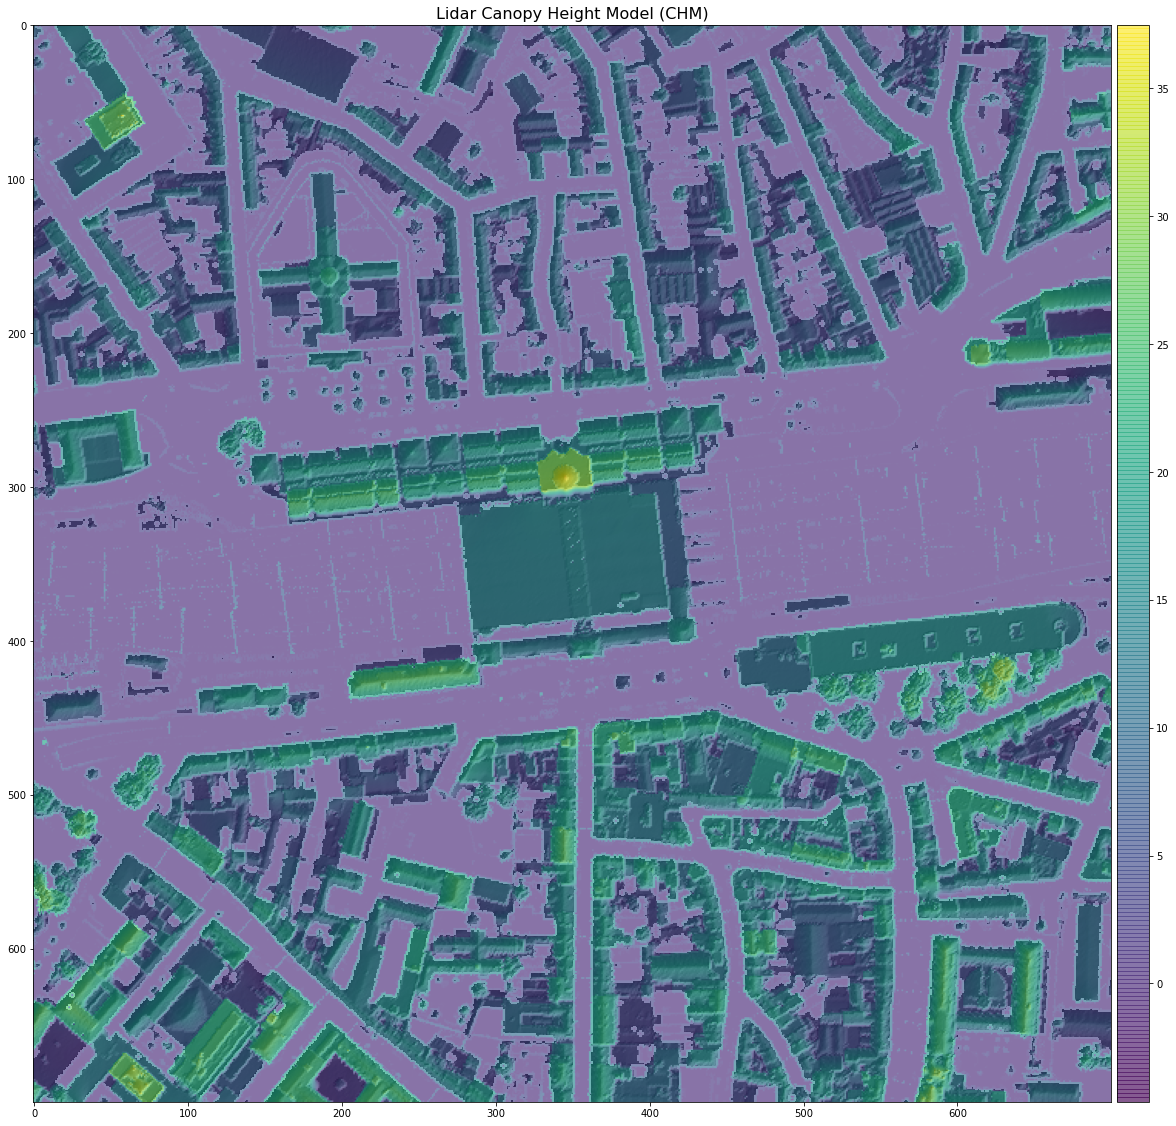

In [50]:
# create hillshade using hillshade function in earthpy
chm_hill = es.hillshade(clean_lidar_chm, 315, 45)

# plot the data
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(chm_hill, cmap='Greys')
chm_plot = ax.imshow(lidar_chm, 
                     cmap='viridis', 
                     alpha = .65)

ep.colorbar(chm_plot)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16);

## Test pylidar

In [81]:
data_all = small_dsm
data_ground = small_dtm


# Function to process
def data_conversion(p):
    xin, yin, zin = p
    return [xin, yinout, zin]

# Process all LiDAR data points
np_all = len(data_all)
x_all = np.zeros(np_all)
y_all = np.zeros(np_all)
z_all = np.zeros(np_all)

for x in tqdm(range(np_all)):
    x_all[x],y_all[x],z_all[x] = data_conversion(data_all[x])

# Process only Ground LiDAR data points
np_ground = len(data_ground)
x_g = np.zeros(np_ground)
y_g = np.zeros(np_ground)
z_g = np.zeros(np_ground)

for x in tqdm(range(np_ground)):
    x_g[x],y_g[x],z_g[x] = data_conversion(data_ground[x])

  0%|                                                                                          | 0/700 [00:00<?, ?it/s]

(700, 700)
(700, 700)


ValueError: too many values to unpack (expected 3)

In [70]:
print(min(z_all))
print(max(z_all))

0.0
0.0


Text(0.5, 0.92, 'All Points')

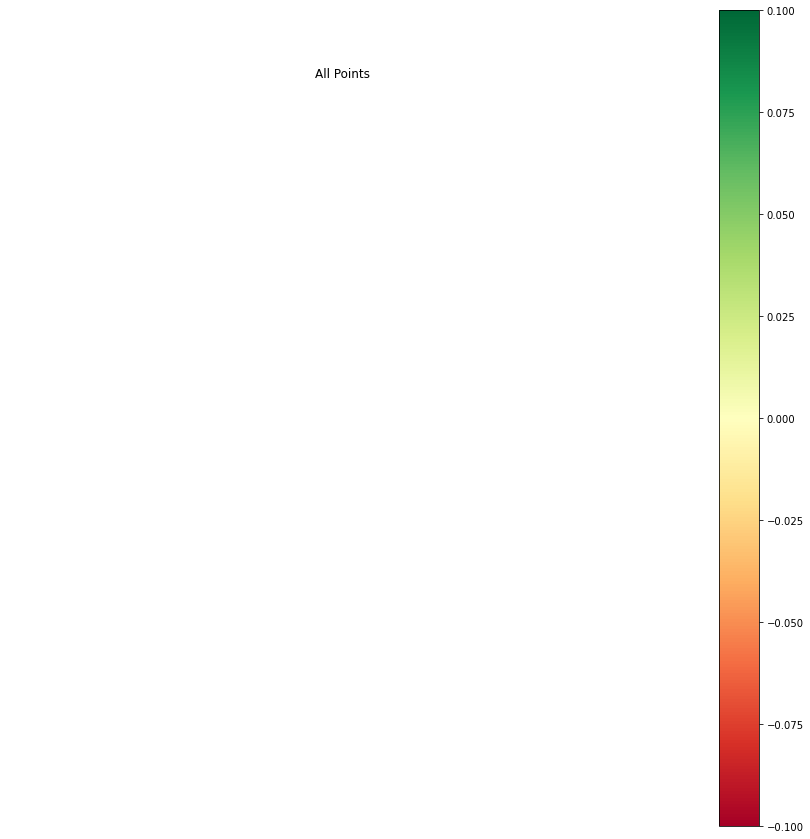

In [69]:
fig1 = plt.figure(figsize=(15,15))

ax = fig1.add_subplot(111, projection = '3d')
ax.axis('off')
plot = ax.scatter3D(xs = x_all, ys = y_all, zs = z_all, c = z_all, cmap = plt.cm.RdYlGn)
ax.set_zlim3d(250,400)
fig1.colorbar(plot)
plt.title("All Points")

In [ ]:
import osgeo.gdal as gdal
import osgeo.osr as osr
import numpy as np
from numpy import ma

def maFromGDAL(filename):
    dataset = gdal.Open(filename, gdal.GA_ReadOnly)

    if dataset is None:
        raise Exception()

    # Get the georeferencing metadata.
    # We don't need to know the CRS unless we want to specify coordinates
    # in a different CRS.
    #projection = dataset.GetProjection()
    geotransform = dataset.GetGeoTransform()

    # We need to know the geographic bounds and resolution of our dataset.
    if geotransform is None:
        dataset = None
        raise Exception()

    # Get the first band.
    band = dataset.GetRasterBand(1)
    # We need to nodata value for our MaskedArray later.
    nodata = band.GetNoDataValue()
    # Load the entire dataset into one numpy array.
    image = band.ReadAsArray(0, 0, band.XSize, band.YSize)
    # Close the dataset.
    dataset = None

    # Create a numpy MaskedArray from our regular numpy array.
    # If we want to be really clever, we could subclass MaskedArray to hold
    # our georeference metadata as well.
    # see here: http://docs.scipy.org/doc/numpy/user/basics.subclassing.html
    # For details.
    masked_image = ma.masked_values(image, nodata, copy=False)
    masked_image.fill_value = nodata

    return masked_image, geotransform

def pixelToMap(gt, pos):
    return (gt[0] + pos[0] * gt[1] + pos[1] * gt[2],
            gt[3] + pos[0] * gt[4] + pos[1] * gt[5])

# Reverses the operation of pixelToMap(), according to:
# https://en.wikipedia.org/wiki/World_file because GDAL's Affine GeoTransform
# uses the same values in the same order as an ESRI world file.
# See: http://www.gdal.org/gdal_datamodel.html
def mapToPixel(gt, pos):
    s = gt[0] * gt[4] - gt[3] * gt[1]
    x = (gt[4] * pos[0] - gt[1] * pos[1] + gt[1] * gt[5] - gt[4] * gt[2]) / s
    y = (-gt[3] * pos[0] + gt[0] * pos[1] + gt[3] * gt[2] - gt[0] * gt[5]) / s
    return (x, y)

def valueAtMapPos(image, gt, pos):
    pp = mapToPixel(gt, pos)
    x = int(pp[0])
    y = int(pp[1])

    if x < 0 or y < 0 or x >= image.shape[1] or y >= image.shape[0]:
        raise Exception()

    # Note how we reference the y column first. This is the way numpy arrays
    # work by default. But GDAL assumes x first.
    return image[y, x]

try:
    image, geotransform = maFromGDAL('myimage.tif')
    val = valueAtMapPos(image, geotransform, (434323.0, 2984745.0))
    print val
except:
    print('Something went wrong.')

## Saving some files

In [ ]:
with rio.open('../Outputs/small_dsm.tiff', 'w', **dsm_meta) as ff:
    ff.write(small_dsm,1)

In [ ]:
with rio.open('../Outputs/small_dtm.tiff', 'w', **dtm_meta) as ff:
    ff.write(small_dtm,1)

In [ ]:
with rio.open('../Outputs/lidar_chm.tiff', 'w', **dsm_meta) as ff:
    ff.write(lidar_chm,1)

TO DO :
    
Flandre :
    "Get the file"
    analyser shapefile pour obtenir coordonnées min/max
    selectionner les bons fichiers
    avoir le système de référence (crs)
    transformer coord das le système de référence
    
Les deux :
    Projection 3D
    Select one house only
    